# iminuit: Past and Future

* Hans Dembinski, TU Dortmund, Germany

PyPI          | https://pypi.org/project/iminuit
 --------------|:--------------------------------------
Code          | https://github.com/scikit-hep/iminuit
Documentation | http://iminuit.readthedocs.org
Gitter        | https://gitter.im/Scikit-HEP/community

## Introduction to iminuit

### iminuit is a frontend to Minuit
- Minuit: General purpose tool to minimize statistical cost functions with box constraints **and to compute parameter uncertainties** (fairly unique to Minuit)
- Robust technology from 1975 that stood the tests of time
- Python frontend to MINUIT2 C++ code used by ROOT
    - Uses original ROOT code
    - MINUIT is driving backend in virtually every HEP analysis

#### Minimization: Migrad algorithm

- Newton-steps with along-the-way updated hessian matrix
- Fallback to steepest descent with line search
- Various heuristics to deal with sticky situations
- Box-constraints implemented via parameter transformations
- Stopping criterion: Estimated distance to minimum (EDM), very well suited to statistics problems

#### Uncertainty computation: Hesse and Minos algorithms
- Hesse algorithm, 1D intervals and ND contours
- Minos algorithm, 1D intervals and ND contours
- Also respect box-constraints
- Different pros and cons, Hesse recommended as default (more later)

### A bit of (version) history

#### Fortran
- Original MINUIT in Fortran (1975)

#### C/C++
- TMinuit: Original ported to C and integrated into ROOT (~2000)
- Minuit2 (aka SEAL Minuit)
    - Ambitious rewrite of MINUIT in C++ (2002-2006)
    - Originally standalone project, now integrated into ROOT

#### Python
- pyminuit, pyminuit2
    - Original Minuit Python wrappers by Jim Pivarski
    - Feature highlight: auto-detection of parameter names in functions
- iminuit
    - Rewrite using Cython by Piti Ongmongkolkul
    - Interface-compatible with pyminuit
    - *i* for interactive: Pretty display of fit status in Jupyter notebooks
    - Intermediate maintainer Christoph Deil (leading developer of [gammapy](https://gammapy.org/))
    - HD took over as maintainer in 2018
    - iminuit joined Scikit-HEP
    - Version 1.3
        - Tighter intergration with numpy
            - Support functions that accept parameters as numpy arrays
            - Access to parameters and covariance matrix as numpy arrays
        - Support for modifying fit state between fitting steps (**key feature** of MINUIT)
            - Fix and release parameters
            - Change parameter values
        - Better code sharing with ROOT C++ (credit: Henry Schreiner, GooFit)
        - Prebuild Python wheels and conda packages for every release (credit: Henry Schreiner, Chris Burr, Matt Craig, Brigitta Sipőcz, Matthew Becker)
        - Added lots and lots of documentation and tutorials
            - Try iminuit tutorials on Binder (credit: Matthew Feickert)
        - Lots of bug-fixes in the interface
        - Allow computing "Hesse" uncertainties without prior call to Migrad 
    - Version 1.4 (current version 1.4.7)
        - Further pythonization of interface
            - Duplicated and legacy interface deprecated
            - Replaced getter/setters with properties
            - Make similar objects work alike
            - Comply with Python/Numpy expectations (e.g. dict-like objects support dict interface)
            - Slicing and broadcasting syntax for `Minuit.values`, `Minuit.errors`, `Minuit.fixed` (more later)
            - Increasing consistency pays off
                - Reduces mental load
                - Makes iminuit easier to teach and learn
        - PDG-rule rounding for values with errors
        - Cost functions (more later)
        - C++ Minuit2 updated to ROOT v6.23-01 (fixes some long-standing minor cornercase bugs)

### Deprecated interface

* Minuit.list_of_fixed_params(), Minuit.list_of_vary_params(): use Minuit.fixed
* Minuit.migrad_ok(): use Minuit.valid
* Minuit.matrix_accurate(): use Minuit.accurate
* Minuit.get_fmin(): use Minuit.fmin
* Minuit.get_param_states(): use Minuit.param
* Minuit.get_initial_param_states(): use Minuit.init_param
* Minuit.get_num_call_fcn(): use Minuit.ncalls_total
* Minuit.get_num_call_grad(): use Minuit.ngrads_total
* Minuit.hesse(maxcall=…) keyword: use ncall=… like in Minuit.migrad()
* Minuit.edm: use Minuit.fmin.edm
* Minuit.is_fixed: replaced by .fixed attribute
* Minuit.set_strategy: assign to Minuit.strategy instead
* Minuit.set_errordef: assign to Minuit.errordef instead
* Minuit.set_print_level: assign to Minuit.print_level instead
* Minuit.print_param_states, Minuit.print_initial_param_states, Minuit.print_fmin, Minuit.print_matrix, Minuit.print_param, Minuit.print_initial_param, Minuit.print_all_minos: use print() on the respective attributes instead

### Why use iminuit and not RooFit, pyhf, zfit ...?

* Learning iminuit is simple, its feature-set is narrow
* Great for simple fits
* Great for experts and power users who need full control over all aspects of the fit


## iminuit and a simple fit

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from iminuit import Minuit

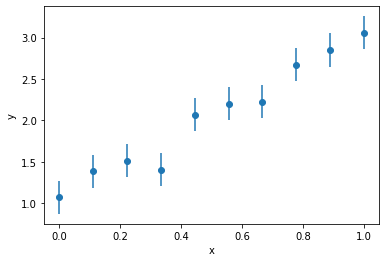

In [2]:
# make 10 data points with scatter on y-coordinate

rng = np.random.default_rng(1)

x = np.linspace(0, 1, 10)
ye = np.ones_like(x) * 0.2
y = rng.normal(2 * x + 1, ye, size=len(x))

plt.errorbar(x, y, ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y");

To recover the parameters of the line, we need to write a model and a cost function. The model predicts a y value for an x value, using a set of parameters. The cost function must compute some kind of distance between the model predictions and the observations.

Optimal for this case is the least-squares method, where the cost function is the sum of squared studentized residuals.

In [3]:
# line model
def model(x, a, b):
    return a + b * x

def cost(a, b):
    ym = model(x, a, b)
    res = (y - ym) / ye # studentized residuals
    return np.sum(res ** 2)

# initialize Minuit object by passing the cost function
# - Minuit uses a local minimizer, we need to set starting values
# - Minuit also needs an `errordef` parameter (more later)
m = Minuit(cost, a=0, b=0, errordef=1)
m.params

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |    0.0    |    0.1    |            |            |         |         |       |
| 1 | b    |    0.0    |    0.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

Note: Minuit detected that the cost function has two parameters named `a` and `b`.

The Minuit object represents the current state of the fit. The initial state consists of the starting values and some step sizes (here 0.1) for the numerical gradient computation. You can set the step sizes yourself, with `error_a=...` etc, but a good default is selected for you if you do not.

Minuit makes it easy to interact with the fitter, which is useful for debugging and to manually help the minimizer to find the minimum. It also presents useful diagnostics that indicate if something went wrong.

In [4]:
# calling Migrad minimizer 
m.migrad()

------------------------------------------------------------------
| FCN = 3.959                   |      Ncalls=34 (34 total)      |
| EDM = 1.09e-22 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.05    |   0.12    |            |            |         |         |       |
| 1 | b    |   1.99    |   0.20    |            |            |         |         |       |
------------------------------------------------------------------------------------------

Values and errors are rounded according to the **PDG rounding rules**.

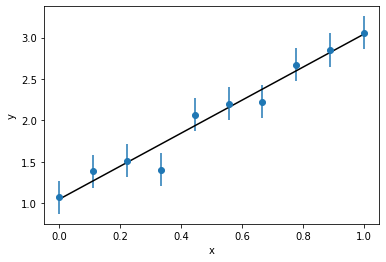

In [5]:
plt.errorbar(x, y, ye, fmt="o")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, model(x, *m.values[:]), color="k"); # trick to access values as a tuple

The "Hesse Errors" now show estimated uncertainties of the parameters. *Migrad* computes these mostly for free as part of its minimization process.

Things to note:
- **EDM**: estimated distance to minimum, must be smaller than "Goal"; shows that Migrad converged
- **Ncalls**: How many function calls were used by Migrad (and the total by this Minuit object so far)
- **Pos. def.**: Whether the Hessian matrix (matrix of second derivatives) is positive definite; it must be for a valid minimum

You can get the values from the `Minuit.fmin` attribute.

In [6]:
print(repr(m.fmin)) # repr() disables the usual pretty printing

FMin(fval=3.9594362732650183, edm=1.0859678150194733e-22, tolerance=0.1, nfcn=34, ncalls=34, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False)


"Minos Errors" are not automatically computed. You need to run *Minos* explicitly.

In [7]:
m.minos()

------------------------------------------------------------
|          |           a           |           b           |
------------------------------------------------------------
|  Error   |   -0.12   |   0.12    |   -0.2    |    0.2    |
|  Valid   |   True    |   True    |   True    |   True    |
| At Limit |   False   |   False   |   False   |   False   |
| Max FCN  |   False   |   False   |   False   |   False   |
| New Min  |   False   |   False   |   False   |   False   |
------------------------------------------------------------

In such a simple fit, the Minos and Hesse uncertainty estimates are equal, but in non-parabolic cost functions they are not.

The Minos and Hesse uncertaintes are now nicely comparable in the parameter display:

In [8]:
m.params

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.05    |   0.12    |   -0.12    |    0.12    |         |         |       |
| 1 | b    |   1.99    |   0.20    |   -0.20    |    0.20    |         |         |       |
------------------------------------------------------------------------------------------

The Minos uncertainties can be read-out with the following attribute (read-only).

In [9]:
a_me = m.merrors["a"] # returns a data struct with many fields
print(f"Did Minos work for parameter {a_me.name}? {a_me.is_valid}\n"
      f"lower error={a_me.lower:.3} upper error={a_me.upper:.3}")

Did Minos work for parameter a? True
lower error=-0.118 upper error=0.118


Much more information can be pulled from this object. Try `dir(a_me)`.

## Interactively manipulate fit state

Let's mess around. Let's say we know that `a = 1`, what is the value of `b` then? We can fix `a` and set its value, and then run *Migrad* again.

We can manipulate Minuit with the attributes `m.values`, `m.fixed`, and `m.errors` (to set different step sizes).

In [10]:
m.values["a"] = 1
m.fixed["a"] = True
m.migrad()

------------------------------------------------------------------
| FCN = 4.127                   |      Ncalls=8 (66 total)       |
| EDM = 1.51e-20 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.00    |   0.12    |   -0.12    |    0.12    |         |         |  yes  |
| 1 | b    |   2.06    |   0.11    |   -0.20    |    0.20    |         |         |       |
------------------------------------------------------------------------------------------

This took Minuit only 8 calls, because it was already close to the minimum and because it could *reuse information from the previous minimization*. This is another **key feature** of Minuit and iminuit.

The value and error of `b` changed a bit. Let's see how `b` varies when we scan over `a`.

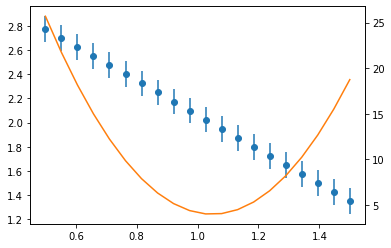

In [11]:
a = np.linspace(0.5, 1.5, 20)
b = []
be = []
fval = []
for ai in a:
    m.values["a"] = ai
    m.migrad()
    assert m.valid # assert that fit is valid
    fval.append(m.fval) # get value of cost function
    b.append(m.values["b"])
    be.append(m.errors["b"])

# values and uncertainty of b as a function of a, also shown is the function minimum
plt.errorbar(a, b, be, fmt="o", color="C0")
plt.twinx()
plt.plot(a, fval, color="C1");

The uncertainty estimate does not change, because the cost function has a constant second derivative, and Minuit uses the second derivative by default to estimate the uncertainty ("Hesse method").

Let's see how the corresponding lines look like. 

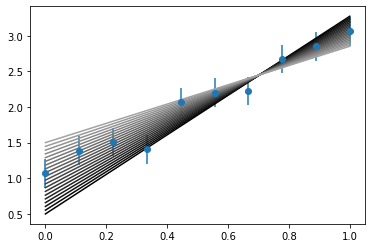

In [12]:
plt.errorbar(x, y, ye, fmt="o")
for i, (ai, bi) in enumerate(zip(a, b)):
    plt.plot(x, model(x, ai, bi), color=f"{i / 30.}")

**Mechanical analog**: **stiff rod** attached to the data points with **springs** of constant tension. If both `a` and `b` are minimized, Migrad finds the minimum energy configuration. This is also true, if `a` is externally constrained to other values (fixed during minimization).

## Cost functions

Minuit now comes with builtin cost functions, which can be imported from `iminuit.cost`. Currently available:

- Unbinned negative log-likelihood
- Extended unbinned negative log-likelihood
- Binned negative log-likelihood
- Extended binned negative log-likelihood
- Least-squares
- Robust least-squares

The `errordef` parameter is automatically set correctly for these.

As a particle physicist, you will often fit some peak over background. Let's do that.

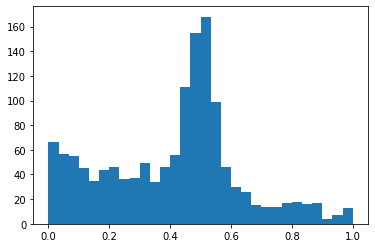

In [13]:
from scipy import stats

rng = np.random.default_rng(1)

x = np.append(stats.norm(0.5, 0.05).rvs(size=500, random_state=rng),
              stats.expon(0.0, 0.5).rvs(size=1000, random_state=rng))

plt.hist(x, bins=30, range=(0, 1));

In [14]:
# extended binned maximum likelihood fit
from iminuit.cost import ExtendedBinnedNLL

n, xe = np.histogram(x, bins=30, range=(0, 1)) # or use boost_histogram here!


# ExtendedBinnedNLL wants a model that returns the expected counts per bin

def signal(xe, ns, mu, sigma):
    return ns * stats.norm(mu, sigma).cdf(xe)


def background(xe, nb, lambd):
    return nb * stats.expon(0.0, lambd).cdf(xe)


def total(xe, ns, mu, sigma, nb, lambd):
    return signal(xe, ns, mu, sigma) + background(xe, nb, lambd)

cost = ExtendedBinnedNLL(n, xe, total)

m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1)
m.migrad()

------------------------------------------------------------------
| FCN = 4351                    |     Ncalls=106 (117 total)     |
| EDM = 5.04e+03 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    1.0    |    0.5    |            |            |         |         |       |
| 1 | mu    |    1.0    |    0.4    |            |            |         |         |       |
| 2 | sigma |   0.55    |   0.13    |            |            |         |         |       |
| 3 | nb    |    1.0    |    0.2    |            |            |         |         |       |
| 4 | lambd |    0.6    |    0.5    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

Uh oh, this does not look good. Let's do this again in verbose mode.

In [15]:
cost.verbose = 1
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1)
m.migrad()

(1.0, 1.0, 1.0, 1.0, 1.0) -> 4674.964736477243
(1.0004721689651892, 1.0, 1.0, 1.0, 1.0) -> 4674.747479989268
(0.9995278310348108, 1.0, 1.0, 1.0, 1.0) -> 4675.182029100815
(1.0037087473289117, 1.0, 1.0, 1.0, 1.0) -> 4673.259222937664
(0.9962912526710882, 1.0, 1.0, 1.0, 1.0) -> 4676.672479454253
(1.0, 1.0004721689651892, 1.0, 1.0, 1.0) -> 4675.082012794044
(1.0, 0.9995278310348108, 1.0, 1.0, 1.0) -> 4674.847538457714
(1.0, 1.0025195417256905, 1.0, 1.0, 1.0) -> 4675.591439464525
(1.0, 0.9974804582743095, 1.0, 1.0, 1.0) -> 4674.340262923246
(1.0, 1.0, 1.0004721689651892, 1.0, 1.0) -> 4675.108461158805
(1.0, 1.0, 0.9995278310348108, 1.0, 1.0) -> 4674.820982318544
(1.0, 1.0, 1.0041063146339098, 1.0, 1.0) -> 4676.2136721107645
(1.0, 1.0, 0.9958936853660902, 1.0, 1.0) -> 4673.713571570834
(1.0, 1.0, 1.0, 1.0004721689651892, 1.0) -> 4674.532834946704
(1.0, 1.0, 1.0, 0.9995278310348108, 1.0) -> 4675.3967755808835
(1.0, 1.0, 1.0, 1.001900763621876, 1.0) -> 4673.2269103671
(1.0, 1.0, 1.0, 0.998099

------------------------------------------------------------------
| FCN = 4351                    |     Ncalls=106 (117 total)     |
| EDM = 5.04e+03 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    1.0    |    0.5    |            |            |         |         |       |
| 1 | mu    |    1.0    |    0.4    |            |            |         |         |       |
| 2 | sigma |   0.55    |   0.13    |            |            |         |         |       |
| 3 | nb    |    1.0    |    0.2    |            |            |         |         |       |
| 4 | lambd |    0.6    |    0.5    |            |            |         |         |       |
-------------------------------------------------------------------------------------------

The problem is that some computations during minimization returned nan. Migrad can recover from that some extend, but it shouldn't happen.

Here, it happens for several reasons:
- `sigma` must be positive, but no limit is set
- `lambd` must be positive, but no limit is set

This is why Minuit supports parameter limits. Adding limits does not change the parameter values at the minimum, but it will distort the parameter uncertainties if the fit converges with a parameter value at its limit.

Let's try again with limits for `sigma` and `lambd`.

In [16]:
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_lambd=(0, None),
           limit_sigma=(0, None))
m.migrad()

(1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.964736477243
(1.0004721689651892, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.747479989268
(0.9995278310348108, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.182029100816
(1.0037087472355666, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4673.259222980564
(0.9962912527644334, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4676.672479411242
(1.0, 1.0004721689651892, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.082012794044
(1.0, 0.9995278310348108, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.847538457715
(1.0, 1.0025195416964237, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.591439457233
(1.0, 0.9974804583035763, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.340262930485
(1.0, 1.0, 1.000472190162915, 1.0, 0.9999999999999998) -> 4675.108467610569
(1.0, 1.0, 0.9995278469947548, 1.0, 0.9999999999999998) -> 4674.820987178124
(1.0, 1.0, 1.0047235693913468, 1.0

(7.936009760107316, 0.5250818351006824, 0.01718337930422198, 4.803510544004273, 0.35422393336555014) -> 1421.1557576954442
(7.11555477124074, 0.5653605338668088, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1326.6405157488578
(7.121079996300257, 0.5653605338668088, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1326.1804457653818
(7.110029546181223, 0.5653605338668088, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1327.1008908014815
(7.123512591637404, 0.5653605338668088, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1325.9779869960262
(7.107596950844076, 0.5653605338668088, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1327.303677331188
(7.11555477124074, 0.5656690102025762, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1328.8009615432204
(7.11555477124074, 0.5650520575310415, 0.05902750362156084, 4.395962711108881, 0.35656374193340623) -> 1324.4871792831511
(7.11555477124074, 0

(58.13064000601268, 0.38906748933029983, 0.28134194438033133, 29.220797746725342, 0.5039857371235605) -> -1413.5190586164235
(58.13064000601268, 0.3894767409427476, 0.28134194438033133, 29.220797746725342, 0.5039857371235605) -> -1413.7429205338522
(58.13064000601268, 0.3889392171767943, 0.28134194438033133, 29.220797746725342, 0.5039857371235605) -> -1413.4485715287196
(58.13064000601268, 0.38920797905977095, 0.2814675780459739, 29.220797746725342, 0.5039857371235605) -> -1413.4107210904174
(58.13064000601268, 0.38920797905977095, 0.2812163299038424, 29.220797746725342, 0.5039857371235605) -> -1413.7813448923464
(58.13064000601268, 0.38920797905977095, 0.281667611704308, 29.220797746725342, 0.5039857371235605) -> -1413.11543980859
(58.13064000601268, 0.38920797905977095, 0.28101640596635, 29.220797746725342, 0.5039857371235605) -> -1414.076052253312
(58.13064000601268, 0.38920797905977095, 0.28134194438033133, 29.250085832359606, 0.5039857371235605) -> -1413.9976954830267
(58.13064000

(3915.439930133315, -5.582091597480815, 8.649423942525502, 1913.3077187353633, 0.921360088793741) -> -3953.1696573309205
(3915.439930133315, -5.582091597480815, 8.649423942525502, 1913.3077187353633, 0.9176019646470144) -> -3953.142856085532
(3896.5056989402783, -5.554610127314976, 8.588738781148617, 1904.0653498485713, 0.9489255114563011) -> -3953.1652037092454
(3905.744978832855, -5.568020177722254, 8.61835061435781, 1908.5753208183417, 0.9345369801660657) -> -3953.243528993926
(3950.0876717438045, -5.568020177722254, 8.61835061435781, 1908.5753208183417, 0.9345369801660657) -> -3953.1889364865906
(3861.4022859219053, -5.568020177722254, 8.61835061435781, 1908.5753208183417, 0.9345369801660657) -> -3953.296310959292
(3905.744978832855, -5.394175041495052, 8.61835061435781, 1908.5753208183417, 0.9345369801660657) -> -3953.1628366019536
(3905.744978832855, -5.741865313949457, 8.61835061435781, 1908.5753208183417, 0.9345369801660657) -> -3953.3219783805957
(3905.744978832855, -5.5680201

(3657.241324272052, -8.770914241147521, 7.761786965423928, 1787.1998166225796, 0.8164425442607455) -> -3954.451742411438
(3657.241324272052, -8.770914241147521, 8.410647837210465, 1787.1998166225796, 0.8164425442607455) -> -3954.397867622508
(3657.241324272052, -8.770914241147521, 7.510656220345208, 1787.1998166225796, 0.8164425442607455) -> -3954.4709579079254
(3657.241324272052, -8.770914241147521, 7.960509159468623, 1789.5251569866325, 0.8164425442607455) -> -3954.4610221078665
(3657.241324272052, -8.770914241147521, 7.960509159468623, 1784.8744762585268, 0.8164425442607455) -> -3954.4079057463227
(3657.241324272052, -8.770914241147521, 7.960509159468623, 1787.1998166225796, 0.8171417059814507) -> -3954.4339136000044
(3657.241324272052, -8.770914241147521, 7.960509159468623, 1787.1998166225796, 0.8157434995531427) -> -3954.436695100178
(3657.241324272052, -8.770914241147521, 7.960509159468623, 1787.1998166225796, 0.8180812971886198) -> -3954.431274885627
(3657.241324272052, -8.77091

(3657.2582222572987, -3.7339610892745854, 2.0909824792041496, 1788.0927127424789, 0.8668588171730287) -> -3955.116172538552
(3657.2582222572987, -3.710239591497677, 2.1015900738546587, 1788.0927127424789, 0.8668588171730287) -> -3955.2744579132564
(3657.2582222572987, -3.710239591497677, 2.080379138486728, 1788.0927127424789, 0.8668588171730287) -> -3955.1540957126613
(3657.2582222572987, -3.710239591497677, 2.0909824792041496, 1790.3461103333511, 0.8668588171730287) -> -3955.281278845603
(3657.2582222572987, -3.710239591497677, 2.0909824792041496, 1785.8393151516066, 0.8668588171730287) -> -3955.147562277705
(3657.2582222572987, -3.710239591497677, 2.0909824792041496, 1788.0927127424789, 0.8686213871231467) -> -3955.165917400376
(3657.2582222572987, -3.710239591497677, 2.0909824792041496, 1788.0927127424789, 0.8650969165865681) -> -3955.2629370585078
(3657.2584321121913, -3.652399092933889, 2.0571029426521714, 1788.1015733135694, 0.8682066107652493) -> -3955.2255692158824
(3657.259271

(3657.268151146961, -1.9170594399496355, 1.2495495740089808, 1788.5756014600322, 0.9120173233517348) -> -3957.311660946532
(3657.268151146961, -1.9170594399496355, 1.2528436416463613, 1791.0495229944768, 0.9120173233517348) -> -3957.3105388701715
(3657.268151146961, -1.9170594399496355, 1.2528436416463613, 1786.1016799255876, 0.9120173233517348) -> -3957.3346109091353
(3657.268151146961, -1.9170594399496355, 1.2528436416463613, 1788.5756014600322, 0.9140098078420911) -> -3957.3383671321544
(3657.268151146961, -1.9170594399496355, 1.2528436416463613, 1788.5756014600322, 0.9100256203655142) -> -3957.3067506515426
(3657.2683363362544, -1.9170138637130079, 1.2546067692802496, 1788.582157713196, 0.9122610994975564) -> -3957.3313439468257
(3657.269077093429, -1.916831558766497, 1.261662649249201, 1788.6083827258517, 0.9132363210147758) -> -3957.3596416192677
(3657.2709289863656, -1.9163757964002202, 1.2793256612892612, 1788.6739452574905, 0.9156751917825692) -> -3957.41046570195
(3657.273310

(3657.3044663781798, -0.7909970909059617, 0.8939217167420737, 1787.7600273034977, 1.5945920093374077) -> -3959.517151295434
(3657.3044663781798, -0.7909970909059617, 0.8939217167420737, 1787.7600273034977, 1.5872622458086543) -> -3959.4167396319785
(3657.3042480373965, -0.7731022364649608, 0.8845147608264967, 1787.6987276076193, 1.6132272569241728) -> -3959.5549628364784
(3657.303374674263, -0.7015228187009571, 0.8470734258411015, 1787.453528824105, 1.702748468995094) -> -3959.7156996794183
(3667.2866529200874, -0.7015228187009571, 0.8470734258411015, 1787.453528824105, 1.702748468995094) -> -3959.6337866568224
(3647.320096428439, -0.7015228187009571, 0.8470734258411015, 1787.453528824105, 1.702748468995094) -> -3959.795405319112
(3657.303374674263, -0.6996954610115493, 0.8470734258411015, 1787.453528824105, 1.702748468995094) -> -3959.65285979239
(3657.303374674263, -0.7033501763903649, 0.8470734258411015, 1787.453528824105, 1.702748468995094) -> -3959.776199014652
(3657.303374674263,

(3662.0604983228845, -0.2019408231072645, 0.7242612632808276, 1770.6424253238147, 7.847392242715996) -> -3979.5635463723793
(3651.5386563034167, -0.2019408231072645, 0.7242612632808276, 1770.6424253238147, 7.847392242715996) -> -3979.7535519542935
(3656.7995773131506, -0.20082870122347357, 0.7242612632808276, 1770.6424253238147, 7.847392242715996) -> -3979.5843263632364
(3656.7995773131506, -0.20305294499105542, 0.7242612632808276, 1770.6424253238147, 7.847392242715996) -> -3979.7329593425015
(3656.7995773131506, -0.2019408231072645, 0.7258790506597508, 1770.6424253238147, 7.847392242715996) -> -3979.589668060132
(3656.7995773131506, -0.2019408231072645, 0.7226442448373553, 1770.6424253238147, 7.847392242715996) -> -3979.7277868201913
(3656.7995773131506, -0.2019408231072645, 0.7242612632808276, 1781.6337446817079, 7.847392242715996) -> -3979.539289583365
(3656.7995773131506, -0.2019408231072645, 0.7242612632808276, 1759.6511059659215, 7.847392242715996) -> -3979.778825953483
(3656.799

(3647.2874439576644, -0.11245356788790636, 0.6485046248813733, 1615.3297833946122, 61.36825772292122) -> -3992.5131177537805
(3645.842845879346, -0.1141761897717377, 0.6493435806097023, 1592.959065553828, 69.6560608847002) -> -3992.8161623665906
(3642.111545096206, -0.11862560755836207, 0.6515116947152138, 1535.1769888284598, 89.77229951355717) -> -3993.2532264113647
(3640.272636507992, -0.12081842798638694, 0.6525808201151826, 1506.700067960749, 99.6864786131139) -> -3993.3613597303506
(3638.384474902729, -0.12306998054640612, 0.6536789967029799, 1477.4604260540425, 109.86629835833307) -> -3993.4204892206913
(3637.2054387967373, -0.12447593105159596, 0.6543649510750948, 1459.2021406201225, 116.22298458960233) -> -3993.4350478844995
(3641.5709503525723, -0.12447593105159596, 0.6543649510750948, 1459.2021406201225, 116.22298458960233) -> -3993.404956135971
(3632.8399272409024, -0.12447593105159596, 0.6543649510750948, 1459.2021406201225, 116.22298458960233) -> -3993.463191564336
(3637.2

(1774.8697301059085, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.28358467073
(1769.8902870869722, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.649471093814
(1772.3800085964403, 0.33872938537135483, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.4882102675124
(1772.3800085964403, 0.3372118538001248, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.4425520457644
(1772.3800085964403, 0.3384423642736671, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.481113678802
(1772.3800085964403, 0.33749887489781255, 0.304916315228579, -27324.698295033435, 10138.621739362072) -> -4067.4527270891426
(1772.3800085964403, 0.3379706195857398, 0.3055946413497266, -27324.698295033435, 10138.621739362072) -> -4067.47885900716
(1772.3800085964403, 0.3379706195857398, 0.3042384904537099, -27324.698295033435, 10138.621739362072) -> -4067.4519846984367
(1772.3800

/Users/hdembinski/Extern/iminuit/src/iminuit/cost.py:12: RuntimeWarning: invalid value encountered in log
  return np.log(x + log_const)


------------------------------------------------------------------
| FCN = -4067                   |    Ncalls=1081 (1081 total)    |
| EDM = 9.22 (Goal: 0.0001)     |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |        True        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |  1.77e3   |  0.12e3   |            |            |         |         |       |
| 1 | mu    |   0.338   |   0.033   |            |            |         |         |       |
| 2 | sigma |   0.30    |   0.04    |            |            |    0    |         |       |
| 3 | nb    |  -27.3e3  |   1.8e3   |            |            |         |         |       |
| 4 | lambd |  10.1e3   |   0.6e3   |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

This looks better, more green, but still a failure. This time, Minuit gave up because it ran over its call limit. We didn't set a call limit, but Minuit uses a heuristic in this case to not iterate forever. In fact, that was not the only problem, another NaN result was encountered.

Let's try again with an increased the call limit.

In [17]:
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_lambd=(0, None),
           limit_sigma=(0, None))
m.migrad(ncall=1e6)

(1.0, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.964736477243
(1.0004721689651892, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.747479989268
(0.9995278310348108, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.182029100816
(1.0037087472355666, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4673.259222980564
(0.9962912527644334, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4676.672479411242
(1.0, 1.0004721689651892, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.082012794044
(1.0, 0.9995278310348108, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.847538457715
(1.0, 1.0025195416964237, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4675.591439457233
(1.0, 0.9974804583035763, 0.9999999999999998, 1.0, 0.9999999999999998) -> 4674.340262930485
(1.0, 1.0, 1.000472190162915, 1.0, 0.9999999999999998) -> 4675.108467610569
(1.0, 1.0, 0.9995278469947548, 1.0, 0.9999999999999998) -> 4674.820987178124
(1.0, 1.0, 1.0047235693913468, 1.0

(4.531668948568443, 0.6206385781429776, 0.36096358731881417, 3.107884408124756, 0.36287591216951753) -> 2004.1842166873118
(4.531668948568443, 0.6206385781429776, 0.3589443733719211, 3.107884408124756, 0.36287591216951753) -> 2001.6605345062808
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.11147348213025, 0.36287591216951753) -> 2002.2226273764863
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.104295334119262, 0.36287591216951753) -> 2003.6216134133579
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.113143546531879, 0.36287591216951753) -> 2001.8973949798133
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.1026252697176333, 0.36287591216951753) -> 2003.9473561999791
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.107884408124756, 0.363289225894573) -> 2003.0331234384973
(4.531668948568443, 0.6206385781429776, 0.3599535391802504, 3.107884408124756, 0.3624627445783011) -> 2002.8111334684097
(4.531668948568443, 0.6206

(12.130168345970038, 0.47850185957092606, 0.08495598442537466, 6.824263379252518, 0.30475845033733817) -> 397.6200273063848
(13.529121508033002, 0.47852230481217084, 0.11772338007645988, 7.496200609816606, 0.2822016389614317) -> 256.9846951883165
(16.29364510845816, 0.47856270741711177, 0.19503953323291356, 8.824040870858266, 0.23942193115236643) -> 49.379817219521
(21.058160906056443, 0.4786323392514993, 0.3598043302537244, 11.112506015249526, 0.17193833650565793) -> 21.145173750066583
(18.998421789863613, 0.4786022368404437, 0.284357591722451, 10.123183831382988, 0.20007769639551354) -> -4.336613636904019
(18.99915070299559, 0.4786022368404437, 0.284357591722451, 10.123183831382988, 0.20007769639551354) -> -4.37283260915429
(18.997692876731637, 0.4786022368404437, 0.284357591722451, 10.123183831382988, 0.20007769639551354) -> -4.300393539058444
(18.9994651638578, 0.4786022368404437, 0.284357591722451, 10.123183831382988, 0.20007769639551354) -> -4.388457510705184
(18.997378415869427,

(283.1760368875995, 0.04550545292628773, 0.8674734588704474, 138.76012642840925, 0.3719682264609032) -> -2659.931710653855
(283.1760368875995, 0.04550545292628773, 0.8674734588704474, 138.99113925690762, 0.37781293759600754) -> -2660.8487057177404
(283.1760368875995, 0.04550545292628773, 0.8674734588704474, 138.99113925690762, 0.3661516014868458) -> -2660.818332199409
(283.1760368875995, 0.04550545292628773, 0.8674734588704474, 138.99113925690762, 0.3725514396037939) -> -2660.899750269851
(283.1760368875995, 0.04550545292628773, 0.8674734588704474, 138.99113925690762, 0.37138529417602406) -> -2660.89688894521
(315.41380667065386, -0.004949415347285366, 0.9234821394961932, 154.7407452171666, 0.38341364240028275) -> -2743.1442987473106
(444.3648858028714, -0.20676888844157776, 1.1531456169043501, 217.73916905820244, 0.4302156771147596) -> -2989.6658529940605
(620.8343422727763, -0.4829586881831932, 1.4784577391355596, 303.9524655152983, 0.4966913378550468) -> -3208.8666037102585
(815.886

(3657.2487874697854, -5.18059705539762, 7.598580945041546, 1787.1802765942525, 0.8486313945817614) -> -3953.8554016441035
(3657.2487874697854, -5.18059705539762, 8.09537399570217, 1789.506400434015, 0.8486313945817614) -> -3953.874811318721
(3657.2487874697854, -5.18059705539762, 8.09537399570217, 1784.85415275449, 0.8486313945817614) -> -3953.873587648274
(3657.2487874697854, -5.18059705539762, 8.09537399570217, 1787.1802765942525, 0.850392569716613) -> -3953.87422665015
(3657.2487874697854, -5.18059705539762, 8.09537399570217, 1787.1802765942525, 0.8468709132381795) -> -3953.8741724149613
(3665.3486690143245, -5.18059705539762, 8.09537399570217, 1787.1802765942525, 0.8486313945817614) -> -3953.869696550768
(3649.1489059252463, -5.18059705539762, 8.09537399570217, 1787.1802765942525, 0.8486313945817614) -> -3953.8805176230453
(3657.2487874697854, -5.15371958364943, 8.09537399570217, 1787.1802765942525, 0.8486313945817614) -> -3953.867472529113
(3657.2487874697854, -5.207474527145811, 

(3591.713208419179, -5.332707027516557, 3.136273842366455, 1787.8938014025603, 0.8340792947194198) -> -3955.0024369842968
(3657.2532843165345, -5.285620644516897, 3.136273842366455, 1787.8938014025603, 0.8340792947194198) -> -3955.1191807204646
(3657.2532843165345, -5.379793410516217, 3.136273842366455, 1787.8938014025603, 0.8340792947194198) -> -3954.980781000005
(3657.2532843165345, -5.332707027516557, 3.166779374175797, 1787.8938014025603, 0.8340792947194198) -> -3955.097058436121
(3657.2532843165345, -5.332707027516557, 3.1057822714021155, 1787.8938014025603, 0.8340792947194198) -> -3955.001485911758
(3657.2532843165345, -5.332707027516557, 3.155945557429228, 1787.8938014025603, 0.8340792947194198) -> -3955.0814066203807
(3657.2532843165345, -5.332707027516557, 3.116607933545292, 1787.8938014025603, 0.8340792947194198) -> -3955.019786424837
(3657.2532843165345, -5.332707027516557, 3.136273842366455, 1790.1199678378107, 0.8340792947194198) -> -3955.1017918077646
(3657.2532843165345,

(3657.2659988288387, -1.6993948140982726, 1.102744541135162, 1788.3653585075137, 0.939816917156709) -> -3956.987477424112
(3657.2668671936444, -1.4796493057119409, 1.0075972331663698, 1788.3928018908534, 0.9513502486920649) -> -3956.6778154600242
(3657.266042247079, -1.688407538678956, 1.0979553558569908, 1788.3667306766806, 0.9421388049481905) -> -3956.9864043806506
(3686.021923495386, -1.688407538678956, 1.0979553558569908, 1788.3667306766806, 0.9421388049481905) -> -3956.995675041956
(3628.510160998772, -1.688407538678956, 1.0979553558569908, 1788.3667306766806, 0.9421388049481905) -> -3956.975270880608
(3657.266042247079, -1.6833496405434427, 1.0979553558569908, 1788.3667306766806, 0.9421388049481905) -> -3957.014773430636
(3657.266042247079, -1.6934654368144695, 1.0979553558569908, 1788.3667306766806, 0.9421388049481905) -> -3956.9561022855987
(3657.266042247079, -1.688407538678956, 1.10104038552149, 1788.3667306766806, 0.9421388049481905) -> -3957.026068418497
(3657.266042247079,

(3645.9271313217896, -0.8850035158229214, 0.8954072875646599, 1787.9887054166607, 1.4288772093588817) -> -3958.9889465003407
(3657.2997628888597, -0.8813715760931107, 0.8954072875646599, 1787.9887054166607, 1.4288772093588817) -> -3958.9050287680216
(3657.2997628888597, -0.888635455552732, 0.8954072875646599, 1787.9887054166607, 1.4288772093588817) -> -3958.9879571499687
(3657.2997628888597, -0.883034157699013, 0.8954072875646599, 1787.9887054166607, 1.4288772093588817) -> -3958.926278553335
(3657.2997628888597, -0.8869728739468298, 0.8954072875646599, 1787.9887054166607, 1.4288772093588817) -> -3958.971240789954
(3657.2997628888597, -0.8850035158229214, 0.8981952379466507, 1787.9887054166607, 1.4288772093588817) -> -3958.930053469744
(3657.2997628888597, -0.8850035158229214, 0.8926209180381299, 1787.9887054166607, 1.4288772093588817) -> -3958.9656057964526
(3657.2997628888597, -0.8850035158229214, 0.8973858348369113, 1787.9887054166607, 1.4288772093588817) -> -3958.936138275002
(3657.

(3657.1713299056096, -0.3954472151030329, 0.6881442089560568, 1781.6146272098351, 3.742196190744412) -> -3969.8948307012192
(3657.1713299056096, -0.3954472151030329, 0.6860484957748794, 1781.6146272098351, 3.742196190744412) -> -3969.742529348586
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1787.0956740179392, 3.742196190744412) -> -3969.8049967707034
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1776.133580401731, 3.742196190744412) -> -3969.8330156806032
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1781.6146272098351, 3.750676974489462) -> -3969.824080522725
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1781.6146272098351, 3.7337161127530845) -> -3969.814666398035
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1781.6146272098351, 3.7585960986940723) -> -3969.8277865013965
(3657.1713299056096, -0.3954472151030329, 0.6870961761137517, 1781.6146272098351, 3.725798921763288) -> -3969.809573492497
(3657.16504

(3654.1343306672416, -0.14906271007410626, 0.6428011818634871, 1724.9221093707654, 23.81154496992584) -> -3989.4806042034306
(3654.1343306672416, -0.14906271007410626, 0.6428011818634871, 1724.9221093707654, 23.4999079242018) -> -3989.425694154604
(3654.1343306672416, -0.14906271007410626, 0.6428011818634871, 1724.9221093707654, 23.959407670733356) -> -3989.505967284596
(3654.1343306672416, -0.14906271007410626, 0.6428011818634871, 1724.9221093707654, 23.352049764692975) -> -3989.398929075205
(3653.4062775012326, -0.1353176371512642, 0.6528824259038992, 1712.74795036427, 27.931179601620812) -> -3990.372174488913
(3652.8121754227836, -0.1241014557332883, 0.6611352970672868, 1702.813657778509, 31.420599338005488) -> -3990.638986374147
(3657.3277049786434, -0.1241014557332883, 0.6611352970672868, 1702.813657778509, 31.420599338005488) -> -3990.5578188291574
(3648.296645866924, -0.1241014557332883, 0.6611352970672868, 1702.813657778509, 31.420599338005488) -> -3990.718198338393
(3652.81217

(1928.5919473338574, 0.2997039028929681, 0.4438757876169259, -24948.959540401047, 9311.656680669797) -> -4029.4670268564405
(1924.047955425269, 0.2997039028929681, 0.4438757876169259, -24948.959540401047, 9311.656680669797) -> -4029.363692548162
(1926.3199513795632, 0.3006034961931615, 0.4438757876169259, -24948.959540401047, 9311.656680669797) -> -4029.3164312316235
(1926.3199513795632, 0.2988043095927747, 0.4438757876169259, -24948.959540401047, 9311.656680669797) -> -4029.513676661383
(1926.3199513795632, 0.2997039028929681, 0.444804201975989, -24948.959540401047, 9311.656680669797) -> -4029.033102044383
(1926.3199513795632, 0.2997039028929681, 0.442947923249732, -24948.959540401047, 9311.656680669797) -> -4029.7976094569153
(1926.3199513795632, 0.2997039028929681, 0.4438757876169259, -24769.87732898531, 9311.656680669797) -> -4029.4154933714444
(1926.3199513795632, 0.2997039028929681, 0.4438757876169259, -25128.041751816785, 9311.656680669797) -> -4029.417147061671
(1926.3199513795

(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9631.12174196021) -> -4067.4828110354492
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9616.121742041176) -> -4067.483275710301
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9571.121742285592) -> -4067.4846783653466
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9436.121743032823) -> -4067.488965589503
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9138.621744757427) -> -4067.498854677272
(1774.480354864947, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9138.621744757427) -> -4067.3438659261274
(1770.2796623279337, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 9138.621744757427) -> -4067.6519035454535
(1772.3800085964403, 0.3384422875234212, 0.304916315228579, -27324.698295033435, 9138.621744757427) -> -4067.512282874007
(1772.3800085964403, 0

(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6631.121765441223) -> -4067.6168301246125
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6616.121765612122) -> -4067.617800055135
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6571.1217661294995) -> -4067.6207359275163
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6436.121767725035) -> -4067.629785247084
(1772.3800085964403, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6138.62177148881) -> -4067.651104628014
(1774.4786396878937, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6138.62177148881) -> -4067.497796977453
(1770.281377504987, 0.3379706195857398, 0.304916315228579, -27324.698295033435, 6138.62177148881) -> -4067.8024718647175
(1772.3800085964403, 0.3384415751875267, 0.304916315228579, -27324.698295033435, 6138.62177148881) -> -4067.665541094265
(1772.3800085964403, 0.33

(1533.591266066092, 0.3700438376649868, 0.2736486794318682, -27324.698331844695, 4638.621581012098) -> -4078.1690646848097
(1533.6067138542846, 0.3700202254446007, 0.2736954235985405, -27324.698332704884, 4638.621575944851) -> -4078.169078871918
(1535.4220323052166, 0.3700202254446007, 0.2736954235985405, -27324.698332704884, 4638.621575944851) -> -4078.168109121698
(1531.7913954033527, 0.3700202254446007, 0.2736954235985405, -27324.698332704884, 4638.621575944851) -> -4078.16810385042
(1533.6067138542846, 0.3704105122732228, 0.2736954235985405, -27324.698332704884, 4638.621575944851) -> -4078.1681341505146
(1533.6067138542846, 0.36962993861597865, 0.2736954235985405, -27324.698332704884, 4638.621575944851) -> -4078.1680762405426
(1533.6067138542846, 0.3700202254446007, 0.27404286174857706, -27324.698332704884, 4638.621575944851) -> -4078.168120596108
(1533.6067138542846, 0.3700202254446007, 0.2733481376781932, -27324.698332704884, 4638.621575944851) -> -4078.1680886020695
(1533.606713

(1456.1307665459854, 0.3757007059674684, 0.26150906990319256, 330018.7233671022, 5491.239526342253) -> -4078.7086864917696
(1457.94977382066, 0.3757007059674684, 0.26150906990319256, 330018.7233671022, 5491.239526342253) -> -4078.6858204384066
(1454.3117592713106, 0.3757007059674684, 0.26150906990319256, 330018.7233671022, 5491.239526342253) -> -4078.729584417069
(1456.1307665459854, 0.376096794625697, 0.26150906990319256, 330018.7233671022, 5491.239526342253) -> -4078.6806619017157
(1456.1307665459854, 0.3753046173092398, 0.26150906990319256, 330018.7233671022, 5491.239526342253) -> -4078.734734450011
(1456.1307665459854, 0.3757007059674684, 0.261866543141384, 330018.7233671022, 5491.239526342253) -> -4078.7025637622223
(1456.1307665459854, 0.3757007059674684, 0.2611517678649633, 330018.7233671022, 5491.239526342253) -> -4078.712870368213
(1456.1307665459854, 0.3757007059674684, 0.26150906990319256, 330199.3184568727, 5491.239526342253) -> -4078.708386147539
(1456.1307665459854, 0.375

(1336.4052507071804, 0.37294060344670055, 0.2471161511432589, 792560.5871051868, 5882.392164886982) -> -4079.335940182075
(1336.4052507071804, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5881.892164894204) -> -4079.335940467293
(1336.4052507071804, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5882.8921648797605) -> -4079.3359404939324
(1336.756257376535, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5882.392164886982) -> -4079.3359034881432
(1336.0542440378258, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5882.392164886982) -> -4079.335899848747
(1336.4754520410513, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5882.392164886982) -> -4079.335939363448
(1336.3350493733094, 0.37294060344670055, 0.2471161511432589, 792741.1987493186, 5882.392164886982) -> -4079.3359386379548
(1336.4052507071804, 0.37301898737676453, 0.2471161511432589, 792741.1987493186, 5882.392164886982) -> -4079.335882250402
(1336.4052507071804, 

------------------------------------------------------------------
| FCN = -4079                   |    Ncalls=489 (1581 total)     |
| EDM = 6.27e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |  1.34e3   |  0.12e3   |            |            |         |         |       |
| 1 | mu    |   0.373   |   0.010   |            |            |         |         |       |
| 2 | sigma |   0.247   |   0.017   |            |            |    0    |         |       |
| 3 | nb    |   0.8e6   |   2.3e6   |            |            |         |         |       |
| 4 | lambd |  0.006e6  |  0.012e6  |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

This time, Minuit converged to something, but it does not seem to be a minimum. The Hessian matrix is not positiv definite.

Let's plot this "solution".

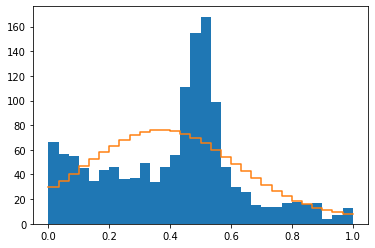

In [18]:
def plot_model(xe, cdf): # helper function
    plt.plot(xe, np.append(np.diff(cdf), np.nan), drawstyle="steps-post")

plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

The fit clearly looks bad. In fact, we only see the signal. The background has a huge amplitude, but also a huge lambda, making it effectively a delta peak at zero. That is not a plausible solution.

We need better starting values. Let's mask out the signal and fit only the background. The cost function has a `mask` attribute for that.

In [19]:
# signal window is roughly 0.3 to 0.7, let's mask that out
cx = 0.5 * (xe[1:] + xe[:-1]) # compute bin centers

cost.mask = (cx < 0.3) | (0.7 < cx)

cost.verbose = 0 # turn verbosity off again, this fit should not cause trouble

m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_lambd=(0, None),
           limit_sigma=(0, None))

# fix signal parameters for next fit and set signal amplitude to zero
m.fixed[:3] = True
m.values["ns"] = 0

m.migrad()

------------------------------------------------------------------
| FCN = -1397                   |     Ncalls=159 (159 total)     |
| EDM = 6.32e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |   0.00    |   0.01    |            |            |         |         |  yes  |
| 1 | mu    |   1.00    |   0.01    |            |            |         |         |  yes  |
| 2 | sigma |   1.00    |   0.01    |            |            |    0    |         |  yes  |
| 3 | nb    |  1.01e3   |  0.06e3   |            |            |         |         |       |
| 4 | lambd |   0.55    |   0.04    |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

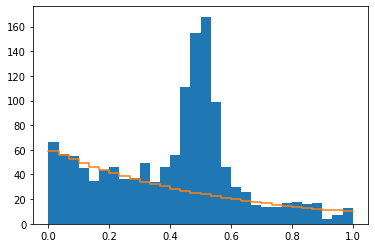

In [20]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

Much better! We now unmask the signal, fix the background parameters and only fit the signal.

In [21]:
cost.mask = None
m.fixed[:] = False
m.fixed["nb"] = True
m.fixed["lambd"] = True
m.values["ns"] = 1
m.migrad()

------------------------------------------------------------------
| FCN = -4292                   |     Ncalls=227 (386 total)     |
| EDM = 3.47e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    510    |    27     |            |            |         |         |       |
| 1 | mu    |  0.4990   |  0.0028   |            |            |         |         |       |
| 2 | sigma |  0.0467   |  0.0028   |            |            |    0    |         |       |
| 3 | nb    |  1.01e3   |  0.06e3   |            |            |         |         |  yes  |
| 4 | lambd |   0.55    |   0.04    |            |            |    0    |         |  yes  |
-------------------------------------------------------------------------------------------

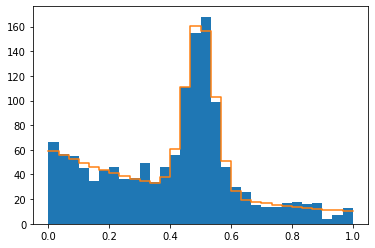

In [22]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

This looks great! To wrap things up, we let Minuit optimize everything together to get the final values and uncertainties.

In [23]:
m.fixed[:] = False
m.migrad()

------------------------------------------------------------------
| FCN = -4293                   |     Ncalls=97 (483 total)      |
| EDM = 2.55e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    501    |    29     |            |            |         |         |       |
| 1 | mu    |  0.4991   |  0.0028   |            |            |         |         |       |
| 2 | sigma |  0.0458   |  0.0029   |            |            |    0    |         |       |
| 3 | nb    |  1.05e3   |  0.05e3   |            |            |         |         |       |
| 4 | lambd |   0.56    |   0.04    |            |            |    0    |         |       |
-------------------------------------------------------------------------------------------

The values changed a bit and the uncertaintes of the signal parameters became larger. That is expected unless the parameters are independent.

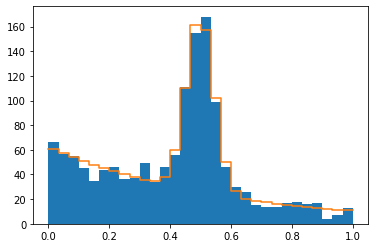

In [24]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

🎉🎉🎉

### Final note: set limits appropriately

We could have gotten the good result right away by setting appropriate limits on all parameters.

In [25]:
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_ns=(0, None),
           limit_nb=(0, None),  
           limit_mu=(0.4, 0.6),
           limit_lambd=(0, 2),
           limit_sigma=(0, 0.2))
m.migrad()

------------------------------------------------------------------
| FCN = -4293                   |     Ncalls=626 (626 total)     |
| EDM = 3.46e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | ns    |    501    |    29     |            |            |    0    |         |       |
| 1 | mu    |  0.4991   |  0.0028   |            |            |   0.4   |   0.6   |       |
| 2 | sigma |  0.0457   |  0.0029   |            |            |    0    |   0.2   |       |
| 3 | nb    |  1.05e3   |  0.05e3   |            |            |    0    |         |       |
| 4 | lambd |   0.56    |   0.04    |            |            |    0    |    2    |       |
-------------------------------------------------------------------------------------------

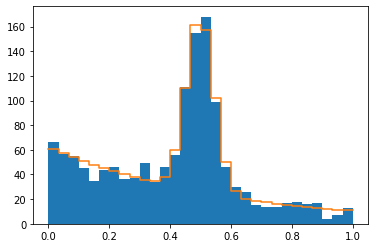

In [26]:
plt.hist(x, bins=30, range=(0, 1));
plot_model(xe, total(xe, *m.values[:]))

As you can see, the result is the same with and without limits within the precision that matters.

Some sources (including the Minuit2 user guide) warn about setting limits carelessly. That advice is correct, but unless a parameter converges to a value very close to a limit boundary, the result with and without limits will be effectively the same. For the parameter value itself, this is a guaranteed proven property. Only the parameter uncertainty may be off.

## Bonus: iminuit and resample

In [27]:
from resample import bootstrap

cost.n = np.histogram(x, bins=30, range=(0, 1))[0]
m = Minuit(cost, ns=1, mu=1, sigma=1, nb=1, lambd=1,
           limit_ns=(0, None),
           limit_nb=(0, None),  
           limit_mu=(0.4, 0.6),
           limit_lambd=(0, 2),
           limit_sigma=(0, 0.2))
m.migrad()
print(f"nfcn for original fit = {m.fmin.nfcn}")

errors = m.errors[:]
nfcn = m.fmin.nfcn

b_value = []
b_nfcn = []
for i, b_sample in enumerate(bootstrap.resample(x, size=50)):
    cost.n = np.histogram(b_sample, bins=30, range=(0, 1))[0]
    m.migrad()
    print(f"nfcn for fit of b_sample[{i}] = {m.fmin.nfcn}")
    assert m.valid
    b_value.append(m.values[:])
    b_nfcn.append(m.fmin.nfcn)

nfcn for original fit = 626
nfcn for fit of b_sample[0] = 89
nfcn for fit of b_sample[1] = 34
nfcn for fit of b_sample[2] = 46
nfcn for fit of b_sample[3] = 37
nfcn for fit of b_sample[4] = 46
nfcn for fit of b_sample[5] = 46
nfcn for fit of b_sample[6] = 34
nfcn for fit of b_sample[7] = 46
nfcn for fit of b_sample[8] = 79
nfcn for fit of b_sample[9] = 92
nfcn for fit of b_sample[10] = 49
nfcn for fit of b_sample[11] = 56
nfcn for fit of b_sample[12] = 49
nfcn for fit of b_sample[13] = 48
nfcn for fit of b_sample[14] = 80
nfcn for fit of b_sample[15] = 38
nfcn for fit of b_sample[16] = 37
nfcn for fit of b_sample[17] = 35
nfcn for fit of b_sample[18] = 81
nfcn for fit of b_sample[19] = 82
nfcn for fit of b_sample[20] = 48
nfcn for fit of b_sample[21] = 45
nfcn for fit of b_sample[22] = 34
nfcn for fit of b_sample[23] = 49
nfcn for fit of b_sample[24] = 35
nfcn for fit of b_sample[25] = 78
nfcn for fit of b_sample[26] = 47
nfcn for fit of b_sample[27] = 80
nfcn for fit of b_sample[28] =

Migrad remembers previous fit result and converges quickly to nearby bootstrapped result.

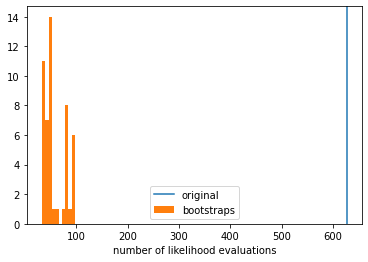

In [28]:
plt.axvline(nfcn, color="C0", label="original")
plt.hist(b_nfcn, color="C1", label="bootstraps")
plt.xlabel("number of likelihood evaluations")
plt.legend();

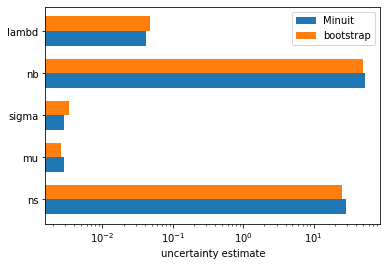

In [29]:
b_cov = np.cov(np.transpose(b_value))
b_errors = np.diag(b_cov) ** 0.5

height = 0.35
i = np.arange(5)
plt.barh(i - height/2, errors, height, label="Minuit")
plt.barh(i + height/2, b_errors, height, label="bootstrap")
plt.semilogx()
# plt.ylim(0, np.max(np.concatenate(errors, b_errors)))
plt.yticks(i, m.parameters)
plt.xlabel("uncertainty estimate")
plt.legend();

## Future plans

* Replace Cython bindings with pybind11 bindings
    * Cython is lagging behind C++ features
    * iminuit requires lots of workarounds because of missing features in Cython
    * pybind11 is not a separate code generator, just C++
* Support unicode parameters

## PS: Check out more great iminuit tutorials

https://nbviewer.jupyter.org/github/scikit-hep/iminuit/tree/master/tutorial/

* How Hesse and Minos really work, which to use when, and is Minos really better? *The answer may surprise you.*
* How to use the new cost functions
* How to combine automatic differentation with JAX with iminuit
* How to use numba to accelerate cost functions